# Background 


### notes about the implementation 
-  both input and recurrent weight are combined into 1 kernel matrix 


In [70]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import matplotlib.pyplot as plt 
%matplotlib inline
import matplotlib.cm as cm
import numpy as np
import tensorflow as tf
import collections
import hashlib
import numbers
from datetime import datetime
from pathlib import Path
import os

import sys
sys.path.append('../')
import spiking_cell_bare as spiking_cell
import adding_problem


In [76]:
# Training Parameters
# Training Parameters
weight_learning_rate = 1e-3
training_steps = 4000
batch_size = 25
training_size=batch_size*training_steps
epochs=50
test_size=1000
display_step = 200
grad_clip=100
buffer_size=600
# Network Parameters
num_input = 2 # adding problem data input (first input are the random digits , second input is the mask)
time_steps = 50
num_units_input_layer=50
num_hidden = 100 # hidden layer num of features
num_output = 1 # value of the addition estimation
#
training_x, training_y = adding_problem.get_batch(batch_size=training_size,time_steps=time_steps)
savepath='/home/eghbal/Desktop/openmind/logs/bptt_snn_addition_dataset/bp_snn_add_T_5e+01_eta_W_1e-03_batch_2e+01_hum_hidd_1e+02_gc_1e+02_steps_4e+03_epoch_5e+01_run_20190309_0213/'

In [77]:
def _hinton_identity_initializer(shape,dtype=None,partition_info=None,verify_shape=None, max_val=1):
    if dtype is None:
        dtype=tf.float32
    #extract second dimension
    W_rec=tf.eye(shape[-1],dtype=dtype)
    new_shape=[shape[0]-shape[-1],shape[-1]]
    W_in=tf.random_normal(new_shape,mean=0,stddev=0.001)
    return tf.concat([W_in,W_rec],axis=0)

## define KeRNL unit
def bptt_snn_all_states(x,context):
    with tf.variable_scope('input_layer') as scope:
        input_layer_cell=spiking_cell.input_spike_cell(num_units=num_units_input_layer)
        output_l1, states_l1 = tf.nn.dynamic_rnn(input_layer_cell, dtype=tf.float32, inputs=x)
    with tf.variable_scope('hidden_layer') as scope:
        hidden_layer_cell=spiking_cell.conductance_spike_cell(num_units=num_hidden,output_is_tuple=True,tau_refract=2.0,tau_m=20.0,kernel_initializer=tf.contrib.layers.xavier_initializer())
        output_hidden, states_hidden = tf.nn.dynamic_rnn(hidden_layer_cell, dtype=tf.float32, inputs=tf.concat([output_l1,context],-1))
    with tf.variable_scope('output_layer') as scope :
        output_layer_cell=spiking_cell.output_spike_cell(num_units=num_output)
        output_voltage, voltage_states=tf.nn.dynamic_rnn(output_layer_cell,dtype=tf.float32,inputs=output_hidden.spike)
    return output_voltage,output_hidden

tf.reset_default_graph()
graph=tf.Graph()
with graph.as_default():

    BATCH_SIZE=tf.placeholder(tf.int64)
    X = tf.placeholder("float", [None, time_steps, num_input])
    Y = tf.placeholder("float", [None, num_output])
    # define a dataset
    dataset=tf.data.Dataset.from_tensor_slices((X,Y)).batch(BATCH_SIZE).repeat()
    dataset = dataset.shuffle(buffer_size=buffer_size)
    iter = dataset.make_initializable_iterator()
    inputs,labels =iter.get_next()
    # define a function for extraction of variable names
    bptt_output,bptt_hidden_states=bptt_snn_all_states(tf.expand_dims(inputs[:,:,0],axis=-1),tf.expand_dims(inputs[:,:,1],axis=-1))
    trainables=tf.trainable_variables()
    variable_names=[v.name for v in tf.trainable_variables()]
    #
    find_join_index = lambda x, name_1,name_2 : [a and b for a,b in zip([np.unicode_.find(k.name, name_1)>-1 for k in x] ,[np.unicode_.find(k.name, name_2)>-1 for k in x])].index(True)
    # find trainable parameters for bptt
    with tf.name_scope('bptt_Trainables') as scope:
        bptt_output_weight_index= find_join_index(trainables,'output_layer','kernel')
        bptt_kernel_index= find_join_index(trainables,'hidden_layer','kernel')
        bptt_weight_training_indices=np.asarray([bptt_kernel_index,bptt_output_weight_index],dtype=np.int)
        bptt_weight_trainables= [trainables[k] for k in bptt_weight_training_indices]

    with tf.name_scope('bptt_train_weights') as scope:
        bptt_weight_optimizer = tf.train.RMSPropOptimizer(learning_rate=weight_learning_rate)
        bptt_loss_output_prediction=tf.losses.mean_squared_error(labels,bptt_output[:,-1,:])
        bptt_grad_cost_trainables=tf.gradients(bptt_loss_output_prediction,bptt_weight_trainables)
        bptt_weight_grads_and_vars=list(zip(bptt_grad_cost_trainables,bptt_weight_trainables))
        bptt_cropped_weight_grads_and_vars=[(tf.clip_by_norm(grad, grad_clip),var) if  np.unicode_.find(var.name,'output')==-1 else (grad,var) for grad,var in bptt_weight_grads_and_vars]
        bptt_weight_train_op = bptt_weight_optimizer.apply_gradients(bptt_cropped_weight_grads_and_vars)


            ##################
            ## bptt train ####
            ##################

    with tf.name_scope("bptt_evaluate") as scope:
        bptt_loss_cross_validiation=tf.losses.mean_squared_error(labels,bptt_output[:,-1,:])

    with tf.name_scope('cross_validation_summary') as scope:
        tf.summary.scalar('cross_validation_summary',bptt_loss_cross_validiation+1e-10)
        bptt_evaluate_summary_op=tf.summary.merge_all(scope="cross_validation_summary")

                ##################
                # SUMMARIES ######
                ##################

    with tf.name_scope("bptt_weight_summaries") as scope:
        tf.summary.histogram('bptt_kernel_grad',bptt_grad_cost_trainables[0]+1e-10)
        tf.summary.histogram('bptt_kernel', trainables[0]+1e-10)
        tf.summary.histogram('bptt_output_weight_grad',bptt_grad_cost_trainables[1]+1e-10)
        tf.summary.histogram('bptt_output_weights', trainables[1]+1e-10)
        tf.summary.scalar('bptt_loss_output_prediction',bptt_loss_output_prediction+1e-10)
        # bptt senstivity tensor and temporal filter
        bptt_merged_summary_op=tf.summary.merge_all(scope="bptt_weight_summaries")
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()


In [82]:
with tf.Session(graph=graph) as sess: 
    
    saver.restore(sess, savepath+'model.ckpt.data-00000-of-00001')
    sess.run(iter.initializer,feed_dict={X: training_x, Y: training_y , BATCH_SIZE: batch_size})
    batch_x,batch_y, outputs,hiddens=sess.run([inputs,labels,bptt_output,bptt_hidden_states])

INFO:tensorflow:Restoring parameters from /home/eghbal/Desktop/openmind/logs/bptt_snn_addition_dataset/bp_snn_add_T_5e+01_eta_W_1e-03_batch_2e+01_hum_hidd_1e+02_gc_1e+02_steps_4e+03_epoch_5e+01_run_20190309_0213/model.ckpt.data-00000-of-00001


DataLossError: Unable to open table file /home/eghbal/Desktop/openmind/logs/bptt_snn_addition_dataset/bp_snn_add_T_5e+01_eta_W_1e-03_batch_2e+01_hum_hidd_1e+02_gc_1e+02_steps_4e+03_epoch_5e+01_run_20190309_0213/model.ckpt.data-00000-of-00001: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?
	 [[node save/RestoreV2 (defined at <ipython-input-77-8eb0d5ee744a>:81)  = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]

Caused by op 'save/RestoreV2', defined at:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/eghbal/venv/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/eghbal/venv/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/eghbal/venv/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/home/eghbal/venv/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 427, in run_forever
    self._run_once()
  File "/usr/lib/python3.6/asyncio/base_events.py", line 1440, in _run_once
    handle._run()
  File "/usr/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/eghbal/venv/lib/python3.6/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/home/eghbal/venv/lib/python3.6/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/eghbal/venv/lib/python3.6/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/home/eghbal/venv/lib/python3.6/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/home/eghbal/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/eghbal/venv/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/eghbal/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/eghbal/venv/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/eghbal/venv/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/home/eghbal/venv/lib/python3.6/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/home/eghbal/venv/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/eghbal/venv/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/eghbal/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/eghbal/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/home/eghbal/venv/lib/python3.6/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/home/eghbal/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/eghbal/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/home/eghbal/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-77-8eb0d5ee744a>", line 81, in <module>
    saver = tf.train.Saver()
  File "/home/eghbal/venv/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1102, in __init__
    self.build()
  File "/home/eghbal/venv/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1114, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/home/eghbal/venv/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1151, in _build
    build_save=build_save, build_restore=build_restore)
  File "/home/eghbal/venv/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 795, in _build_internal
    restore_sequentially, reshape)
  File "/home/eghbal/venv/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 406, in _AddRestoreOps
    restore_sequentially)
  File "/home/eghbal/venv/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 862, in bulk_restore
    return io_ops.restore_v2(filename_tensor, names, slices, dtypes)
  File "/home/eghbal/venv/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1466, in restore_v2
    shape_and_slices=shape_and_slices, dtypes=dtypes, name=name)
  File "/home/eghbal/venv/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/eghbal/venv/lib/python3.6/site-packages/tensorflow/python/util/deprecation.py", line 488, in new_func
    return func(*args, **kwargs)
  File "/home/eghbal/venv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3274, in create_op
    op_def=op_def)
  File "/home/eghbal/venv/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1770, in __init__
    self._traceback = tf_stack.extract_stack()

DataLossError (see above for traceback): Unable to open table file /home/eghbal/Desktop/openmind/logs/bptt_snn_addition_dataset/bp_snn_add_T_5e+01_eta_W_1e-03_batch_2e+01_hum_hidd_1e+02_gc_1e+02_steps_4e+03_epoch_5e+01_run_20190309_0213/model.ckpt.data-00000-of-00001: Data loss: not an sstable (bad magic number): perhaps your file is in a different file format and you need to use a different restore operator?
	 [[node save/RestoreV2 (defined at <ipython-input-77-8eb0d5ee744a>:81)  = RestoreV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save/Const_0_0, save/RestoreV2/tensor_names, save/RestoreV2/shape_and_slices)]]


Text(0, 0.5, 'output class')

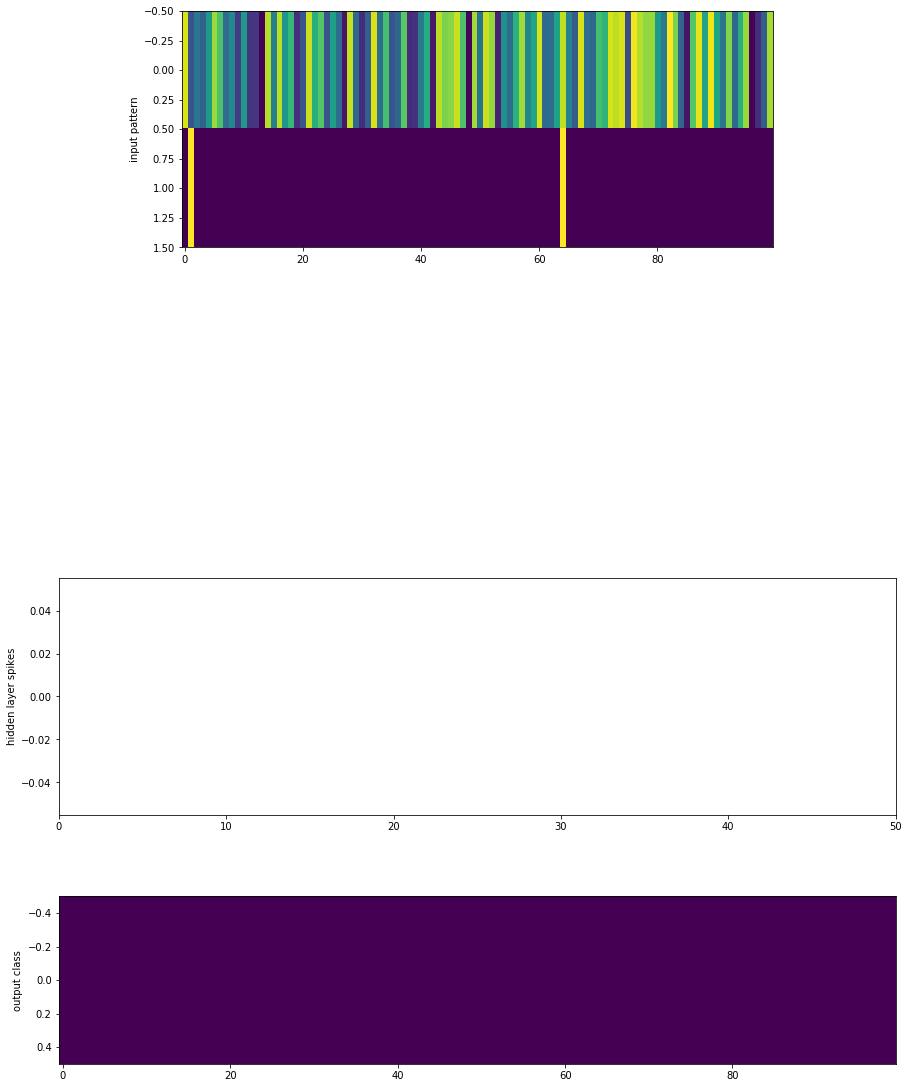

In [69]:
voltages=outputs[9,:,:]
hidden_spikes=hiddens.spike[9,:,:]
plt.figure(figsize=[15,20])


ax1=plt.subplot(411)
plt.imshow(np.transpose(batch_x[9]))
ax1.set_aspect(20)
plt.ylabel('input pattern')

ax3=plt.subplot(413)
colors_map=cm.viridis(np.linspace(0,1,num_hidden))
for t in range(time_steps):
    cross=np.argwhere(hidden_spikes[t,:])
    ax3.scatter(cross*0+t,cross,color=colors_map[cross.flatten(),:],s=2)
    plt.xlim([0,time_steps])
plt.ylabel('hidden layer spikes')
ax1=plt.subplot(414)
ax1.imshow(np.transpose(voltages))
ax1.set_aspect(20)
plt.ylabel('output class')

    

In [57]:
hiddens

LSNNOutputTuple(v_mem=array([[[-0.14455403, -0.15515381, -0.1612929 , ..., -0.13849531,
         -0.13301447, -0.16101669],
        [-0.17575401, -0.19624075, -0.21207899, ..., -0.1691487 ,
         -0.15330105, -0.18895163],
        [-0.27141592, -0.28962296, -0.2898848 , ..., -0.26609606,
         -0.2588755 , -0.26133853],
        ...,
        [-3.0653913 , -3.2898886 , -4.028101  , ..., -3.2592247 ,
         -3.1328359 , -3.1650882 ],
        [-2.9731593 , -3.2043388 , -3.9642048 , ..., -3.2059453 ,
         -3.084337  , -3.115171  ],
        [-3.1075292 , -3.3555293 , -4.138056  , ..., -3.3382552 ,
         -3.2300518 , -3.248547  ]],

       [[-0.15155005, -0.1560784 , -0.19075249, ..., -0.19617541,
         -0.14917819, -0.19135164],
        [-0.285495  , -0.3147714 , -0.41921592, ..., -0.33243182,
         -0.31295195, -0.36607224],
        [-0.48992717, -0.5405247 , -0.703596  , ..., -0.5455955 ,
         -0.54326653, -0.59059536],
        ...,
        [-2.8407066 , -3.1657312

Model saved in path: /tmp/model.ckpt
